In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import pyabf
import tifffile

In [2]:
denoised_movie = np.load('/home/jupyter/bw-data/cellmincer/data/cell_3_1_MMStack_Pos0/denoised_movie_tyx.npy').transpose((0, 2, 1))

In [3]:
denoised_movie.shape

(5000, 512, 100)

In [19]:
save_fig = True
fig_suffix = '_cell_3_1'

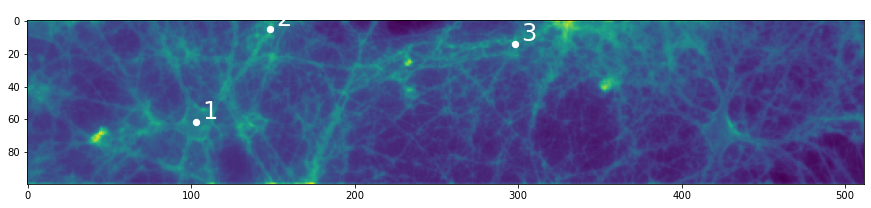

In [5]:
pixs = [(103, 62), (148, 5), (298, 14)]

frame = denoised_movie[1200].copy()
plt.figure(figsize=(15, 12))
plt.imshow(frame.T)
for i, pix in enumerate(pixs):
    plt.text(pix[0] + 4, pix[1] - 2, f'{i + 1}', color='white', fontsize=24)
plt.scatter(*list(zip(*pixs)), color='white', s=40)
if save_fig:
    plt.savefig(f'neuron_pix{fig_suffix}.png')
plt.show()

In [ ]:
# denoised_movie_z = (denoised_movie - denoised_movie.mean(axis=0)) / denoised_movie.std(axis=0)

# pix = pixs[0]
# cor = np.apply_along_axis(np.correlate, 0, denoised_movie_z, v=denoised_movie_z[:, pix[0], pix[1]])[0] / len(denoised_movie_z)

In [6]:
trend = np.load('/home/jupyter/bw-data/cellmincer/data/cell_3_1_MMStack_Pos0/trend.npy')
denoised_movie_notrend = denoised_movie - trend

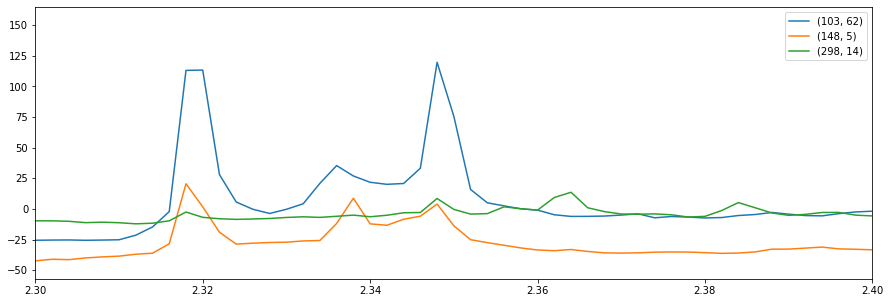

In [7]:
fs = 500

plt.figure(figsize=(15, 5))

for i, pix in enumerate(pixs):
    plt.plot(np.arange(len(denoised_movie_notrend)) / fs, denoised_movie_notrend[:, pix[0], pix[1]], label=str(pix))
plt.legend()

plt.xlim((2.3, 2.4))
plt.show()

In [8]:
raw = tifffile.imread('/home/jupyter/bw-data/miller-ephys/standard_imaging/id_170802_cell_3/cell_3_1_MMStack_Pos0.ome.tif').transpose((0, 2, 1))
abf = pyabf.ABF('/home/jupyter/bw-data/miller-ephys/standard_imaging/id_170802_cell_3/17802002.abf')
abf.setSweep(0)

# x_soma, y_soma = np.nonzero(cor > 0.9)
# denoised_region_notrend = denoised_movie_notrend[..., x_soma, y_soma].mean(axis=1)

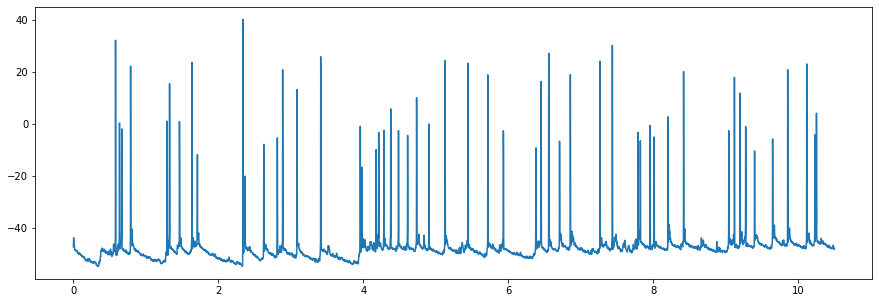

In [9]:
abf_dsX = np.linspace(0, 10.5, num=len(denoised_movie), endpoint=False)
abf_dsY = np.interp(x=abf_dsX, xp=abf.sweepX, fp=abf.sweepY)

plt.figure(figsize=(15, 5))
plt.plot(abf_dsX, abf_dsY)
plt.show()

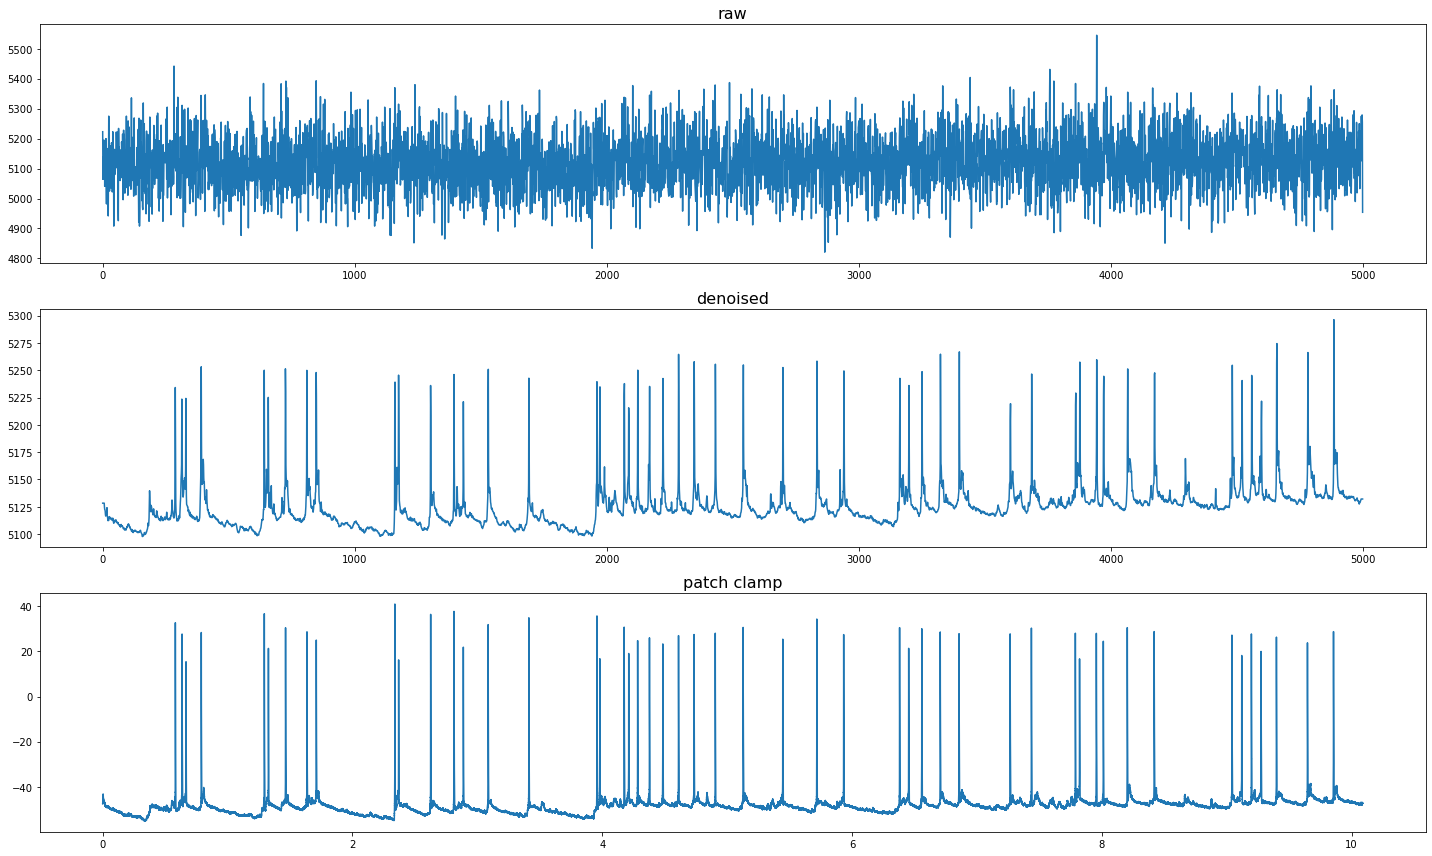

In [27]:
begin, end = 0, 1
i_frame_begin, i_frame_end = int(len(raw) * begin), int(len(raw) * end)
i_ephys_begin, i_ephys_end = int(len(abf.sweepX) * begin), int(len(abf.sweepX) * end)
offset = 0

pix = pixs[0]

# np.argmax(np.correlate(denoised_movie[:, pix[0], pix[1]]), abf.)

fig, axs = plt.subplots(3, figsize=(20, 12))

axs[0].plot(np.arange(i_frame_begin, i_frame_end), raw[i_frame_begin+offset:i_frame_end+offset, pix[0], pix[1]])
axs[1].plot(np.arange(i_frame_begin, i_frame_end), denoised_movie[i_frame_begin+offset:i_frame_end+offset, pix[0], pix[1]])
# axs[1].plot(np.arange(i_frame_begin, i_frame_end), denoised_region_notrend[i_frame_begin+offset:i_frame_end+offset])
axs[2].plot(abf.sweepX[abf.sweepX < 10.088], abf.sweepY[abf.sweepX < 10.088])

axs[0].set_title('raw', size=16)
axs[1].set_title('denoised', size=16)
# axs[1].set_title('denoised region', size=16)
axs[2].set_title('patch clamp', size=16)

fig.tight_layout()

if save_fig:
    fig.savefig(f'/home/jupyter/bw-data/tmp/pix_with_ephys_{fig_suffix}.png')
fig.show()

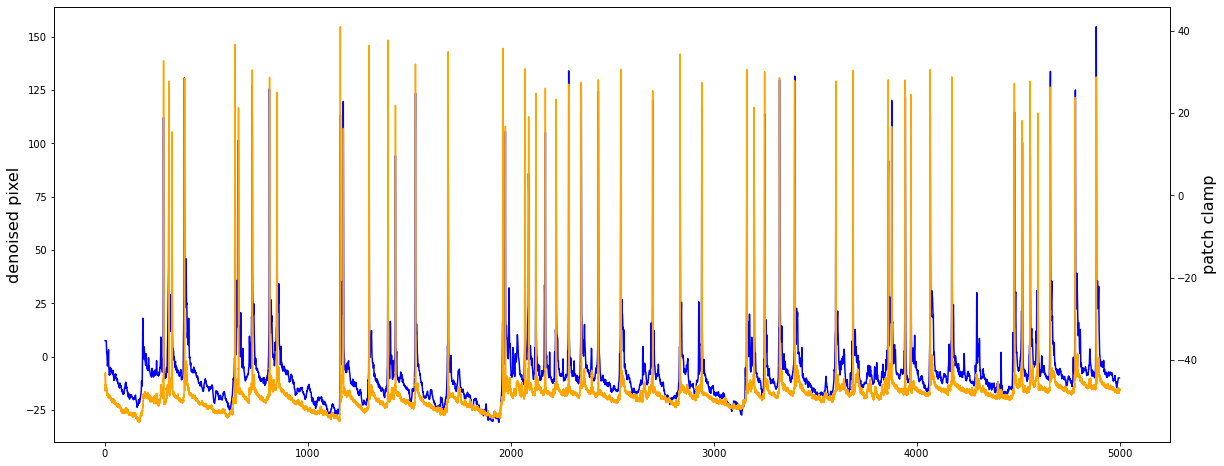

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 8))

patch_end = 10.088

# axs[0].plot(np.arange(i_frame_begin, i_frame_end), raw[i_frame_begin+offset:i_frame_end+offset, pix[0], pix[1]])
ax2 = ax1.twinx()
ax1.plot(np.arange(len(denoised_movie_notrend)), denoised_movie_notrend[:, pix[0], pix[1]], color='blue')
ax2.plot(abf.sweepX[abf.sweepX < patch_end] / patch_end * len(denoised_movie_notrend), abf.sweepY[abf.sweepX < patch_end], color='orange')

# axs[0].set_title('raw', size=16)
ax1.set_ylabel('denoised pixel', size=16)
ax2.set_ylabel('patch clamp', size=16)

if save_fig:
    fig.savefig(f'/home/jupyter/bw-data/tmp/pix_with_ephys_{fig_suffix}.png')
fig.show()

In [12]:
import numpy as np
from scipy.signal import butter, sosfilt, freqz
import matplotlib.pyplot as plt

def butter_pass_filter(data, pass_mode, cutoff, fs, order=10, pad='reflect'):
    assert pass_mode in {'lowpass', 'highpass'}
    if pass_mode == 'highpass' and cutoff == 0:
        return data
    sos = butter(order, cutoff, btype=pass_mode, fs=fs, output='sos')
    if pad is not None:
        pad_order = len(data)
        data = np.pad(data, pad_width=pad_order, mode=pad)
        y = sosfilt(sos, data)[pad_order:-pad_order]
    else:
        y = sosfilt(sos, data)
    return y

In [13]:
order = 10
fs = 500.0       # sample rate, Hz
cutoff_hipass = 1
cutoff_lopass = 20
T = 10
n = int(T * fs)

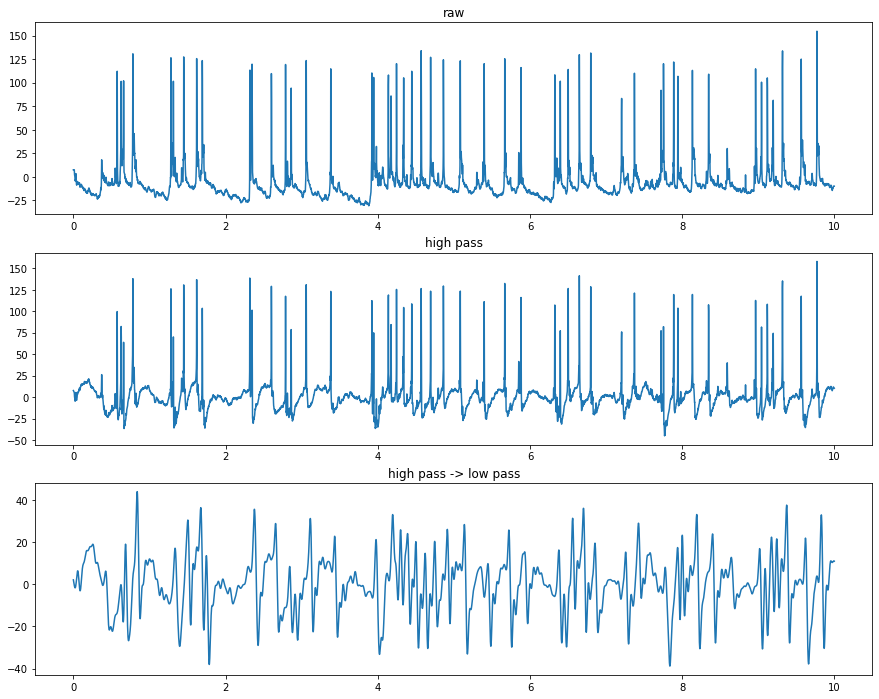

In [14]:
t = np.linspace(0, T, n, endpoint=False)
denoised_y_hi = butter_pass_filter(denoised_movie_notrend[:, pix[0], pix[1]], 'highpass', cutoff_hipass, fs, order)
denoised_y_lo = butter_pass_filter(denoised_y_hi, 'lowpass', cutoff_lopass, fs, order)

fig, axs = plt.subplots(3, figsize=(15, 12))

axs[0].plot(t, denoised_movie_notrend[:, pix[0], pix[1]])
axs[0].set_title('raw')

axs[1].plot(t, denoised_y_hi)
axs[1].set_title('high pass')

axs[2].plot(t, denoised_y_lo)
axs[2].set_title('high pass -> low pass')
plt.show()

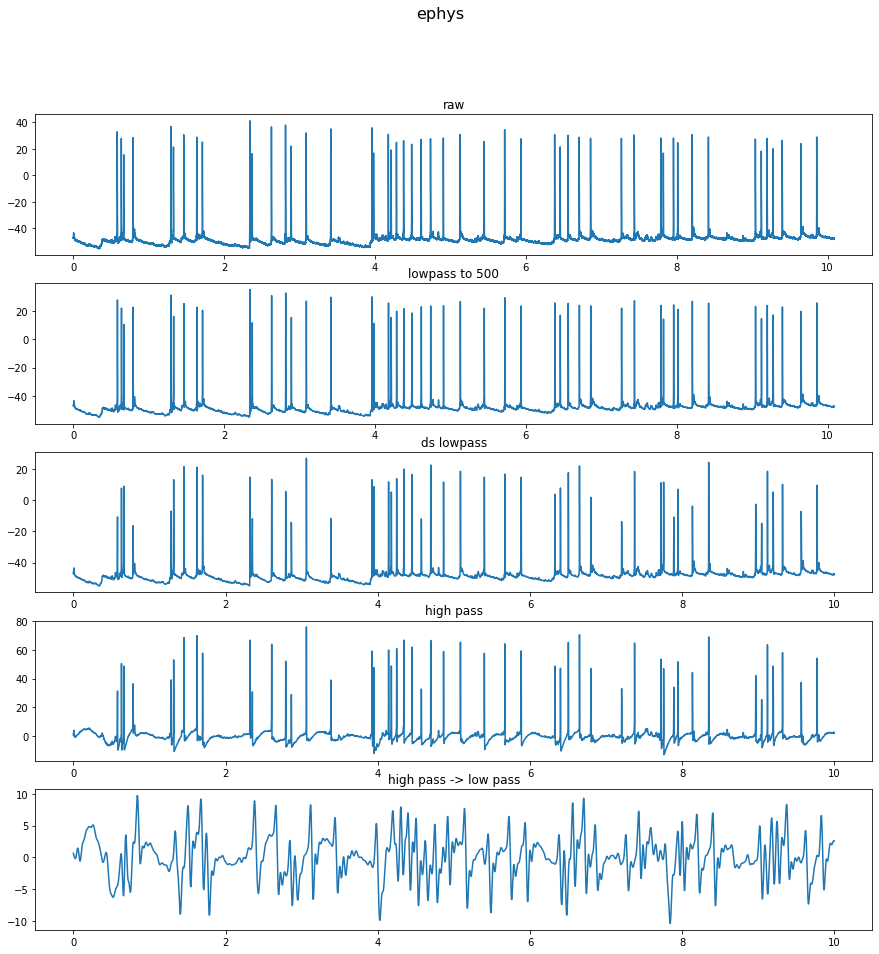

In [15]:
from scipy.interpolate import interpn

ephys_fs = 50000
patch_end = 10.088

sweepX, sweepY = abf.sweepX[abf.sweepX < patch_end], abf.sweepY[abf.sweepX < patch_end]
ephys_y_ds = butter_pass_filter(sweepY, 'lowpass', fs, ephys_fs, order)

# interp
sweepX_ds = np.arange(5000) / 5000
sweepY_ds = interpn(points=(sweepX / patch_end,), values=ephys_y_ds, xi=sweepX_ds)

ephys_y_hi = butter_pass_filter(sweepY_ds, 'highpass', cutoff_hipass, fs, order)

# sweepY_ds = np.interp(x=sweepX_ds, xp=sweepX / patch_end, fp=ephys_y_lo)

t = np.linspace(0, T, n, endpoint=False)
ephys_y_lo = butter_pass_filter(ephys_y_hi, 'lowpass', cutoff_lopass, fs, order)

fig, axs = plt.subplots(5, figsize=(15, 15))

fig.suptitle('ephys', fontsize=16)

axs[0].plot(sweepX, sweepY)
axs[0].set_title('raw')
# axs[0].set_xlim((0, 0.01))

axs[1].plot(sweepX, ephys_y_ds)
axs[1].set_title('lowpass to 500')
# axs[1].set_xlim((0, 0.01))

axs[2].plot(t, sweepY_ds)
axs[2].set_title('ds lowpass')
# axs[2].set_xlim((0, 0.01))

axs[3].plot(t, ephys_y_hi)
axs[3].set_title('high pass')

axs[4].plot(t, ephys_y_lo)
axs[4].set_title('high pass -> low pass')
plt.show()

[0.057  3.9118]


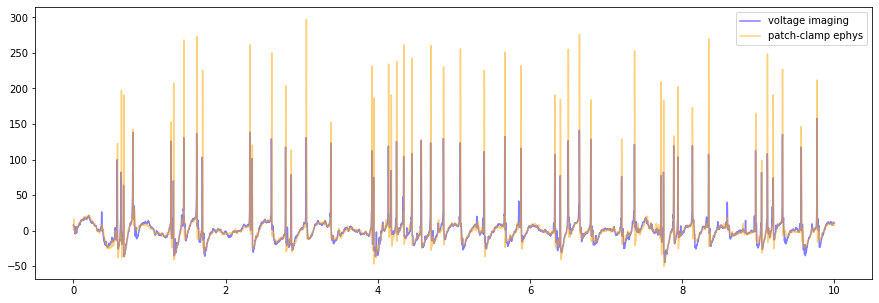

In [21]:
from scipy.optimize import least_squares

fun = lambda x: denoised_y_lo[500:-500] - x[0] - x[1] * ephys_y_lo[500:-500]
result = least_squares(fun, x0=[0, 1])

print(result.x)
plt.figure(figsize=(15, 5))
plt.plot(t, denoised_y_hi, color='blue', alpha=0.5, label='voltage imaging')
plt.plot(t, result.x[0] + result.x[1] * ephys_y_hi, color='orange', alpha=0.5, label='patch-clamp ephys')
plt.legend()

if save_fig:
    plt.savefig(f'aligned{fig_suffix}.pdf')

plt.show()

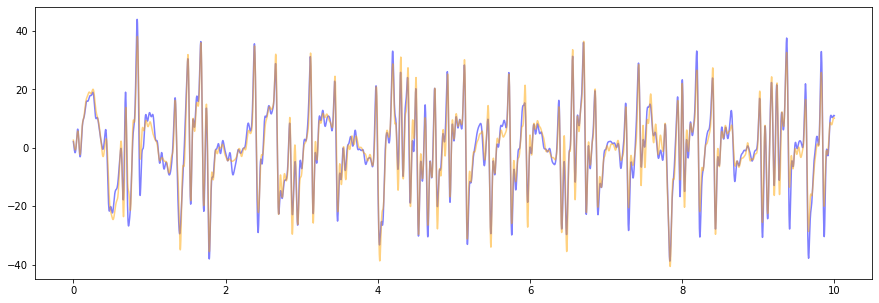

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(t, denoised_y_lo, color='blue', alpha=0.5)
plt.plot(t, result.x[0] + result.x[1] * ephys_y_lo, color='orange', alpha=0.5)
plt.show()

In [ ]:
plt.figure()
plt.specgram(sweepY_ds, cmap='gray', Fs=500)
plt.show()

In [ ]:
%matplotlib inline

patch_end = 10.088

sweepX, sweepY = abf.sweepX[abf.sweepX < patch_end] / patch_end, abf.sweepY[abf.sweepX < patch_end]
sweepX_ds = np.arange(5000) / 5000
sweepY_ds = np.interp(x=sweepX_ds, xp=sweepX, fp=sweepY)

fig, ax1 = plt.subplots(figsize=(20, 12))

patch_end = 10.088

# axs[0].plot(np.arange(i_frame_begin, i_frame_end), raw[i_frame_begin+offset:i_frame_end+offset, pix[0], pix[1]])
ax2 = ax1.twinx()
ax1.plot(np.arange(len(denoised_movie_notrend)) / len(denoised_movie_notrend), denoised_movie_notrend[:, pix[0], pix[1]], color='blue')
ax2.plot(sweepX, sweepY, color='orange')

# axs[0].set_title('raw', size=16)
ax1.set_ylabel('denoised region', size=16)
ax2.set_ylabel('patch clamp', size=16)

if save_fig:
    fig.savefig(f'/home/jupyter/bw-data/tmp/pix_with_ephys_{fig_suffix}.png')
fig.show()

In [ ]:
abf.sweepX[-10:]

In [ ]:
from skvideo import io as skio
from matplotlib.colors import Normalize
import matplotlib.pylab as plt
import numpy as np
import torch
from typing import List, Optional

def normalize_movie(
        movie_txy: np.ndarray,
        n_sigmas: Optional[float] = 8,
        max_intensity=255):
    z_movie_txy  = (movie_txy - movie_txy.mean()) / movie_txy.std()
    norm = Normalize(vmin=0, vmax=n_sigmas, clip=True)
    return max_intensity * norm(z_movie_txy)

In [ ]:
raw_norm_txy = normalize_movie(
    raw,
    n_sigmas=5)

writer = skio.FFmpegWriter(
    '/home/jupyter/bw-data/tmp/raw.avi',
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i_frame in range(len(raw_norm_txy)):
    writer.writeFrame(raw_norm_txy[i_frame].T[None, ...])
writer.close()

In [ ]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
frame = denoised_movie[1200].copy()
plt.figure(figsize=(15, 12))
plt.imshow(frame.T)
plt.show()